In [21]:
import os
import pandas as pd
import torch
import glob
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import timm

In [4]:
# Define paths
dataset_image_path = 'E:\\MRI_Dataset\\T1w_MRI_Brain_Slices\\images\\'
label_path = 'E:\\MRI_Dataset\\T1w_MRI_Brain_Slices\\participants.tsv'

# Load labels
labels_df = pd.read_csv(label_path, sep='\t')
labels_dict = dict(zip(labels_df['participant_id'], labels_df['sex']))

In [27]:
# Define a transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the timm model input size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

In [43]:
# Create a dataset
class MRIDataset(Dataset):
    def __init__(self, dir_path, transform, labels_dict):
        super().__init__()
        self.dir_path = dir_path
        self.transform = transform
        self.labels_dict = labels_dict

        # Find all images in dir_path
        self.image_paths = glob.glob(os.path.join(dir_path, '*.png'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        # Perform additional checks and error handling
        try:
            image = Image.open(image_path)

            # Verify the number of channels and convert to RGB if necessary
            if image.mode != 'RGB':
                image = image.convert('RGB')

            image = self.transform(image)

            # Extract the participant_id from the image filename
            participant_id = os.path.basename(image_path).split('_')[0]

            # Convert labels to integers (F = 0, M = 1)
            label = 0 if self.labels_dict[participant_id] == 'F' else 1

            return image, label, image_path
        except Exception as e:
            # Handle any exceptions during image loading
            print(f"Error loading image: {image_path}\n{str(e)}")
            return None, None

In [44]:
# Create the dataset
dataset = MRIDataset(dataset_image_path, transform, labels_dict)

In [45]:
# Split the dataset into train, test, and validation sets
train_size = int(0.7 * len(dataset))  # 70% of data for training
test_size = int(0.15 * len(dataset))  # 15% of data for testing
valid_size = len(dataset) - train_size - test_size  # 15% of data for validation
train_dataset, test_dataset, valid_dataset = random_split(dataset, [train_size, test_size, valid_size])

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

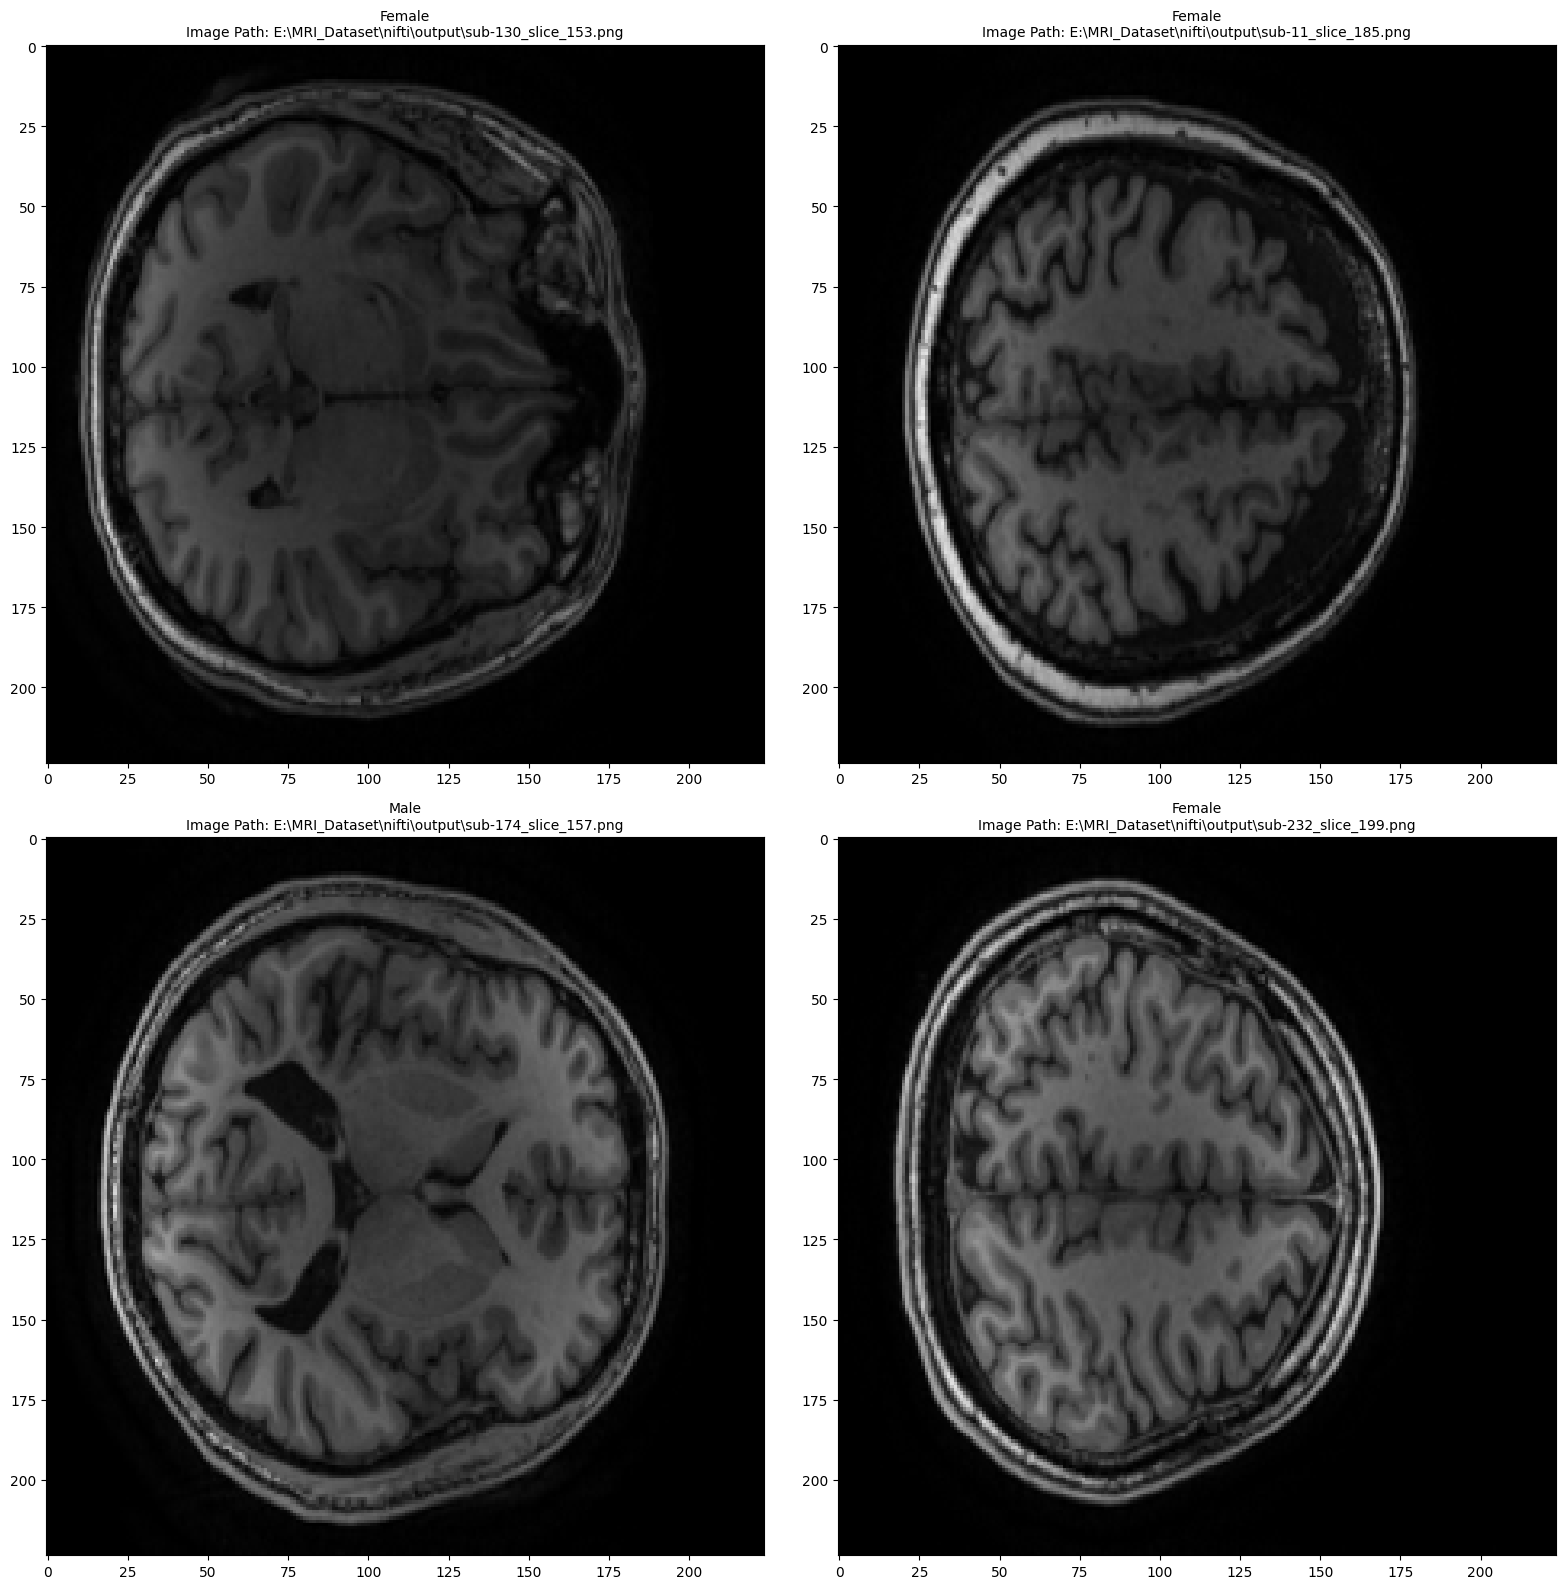

In [50]:
import matplotlib.pyplot as plt

# Display a few sample images from the training set
images, labels, image_paths = next(iter(train_loader))

# Assuming images are grayscale (1 channel). If not, remove the squeeze operation
plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    
    if labels[i] == 0:
        title = f'Female\nImage Path: {image_paths[i]}'
    else:
        title = f'Male\nImage Path: {image_paths[i]}'
    
    plt.title(title, fontsize=10)
plt.tight_layout()
plt.show()

In [32]:
# Load a timm model
model = timm.create_model('resnet50', pretrained=True, num_classes=2)

In [33]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a loss function and an optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Move model to device
model = model.to(device)

# Define the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels, _) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/129], Loss: 0.5847
Epoch [2/10], Step [100/129], Loss: 0.1622
Epoch [3/10], Step [100/129], Loss: 0.0755
Epoch [4/10], Step [100/129], Loss: 0.0246
Epoch [5/10], Step [100/129], Loss: 0.1749
Epoch [6/10], Step [100/129], Loss: 0.0106
Epoch [7/10], Step [100/129], Loss: 0.0073
Epoch [8/10], Step [100/129], Loss: 0.0247
Epoch [9/10], Step [100/129], Loss: 0.0186
Epoch [10/10], Step [100/129], Loss: 0.0127


In [34]:
predictions = []
targets = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get the predicted labels
        _, predicted = torch.max(outputs, dim=1)

        # Save the predictions and targets
        predictions.extend(predicted.tolist())
        targets.extend(labels.tolist())

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(targets, predictions)
precision = precision_score(targets, predictions)
recall = recall_score(targets, predictions)
f1 = f1_score(targets, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9909
Precision: 0.9917
Recall: 0.9863
F1 Score: 0.9890


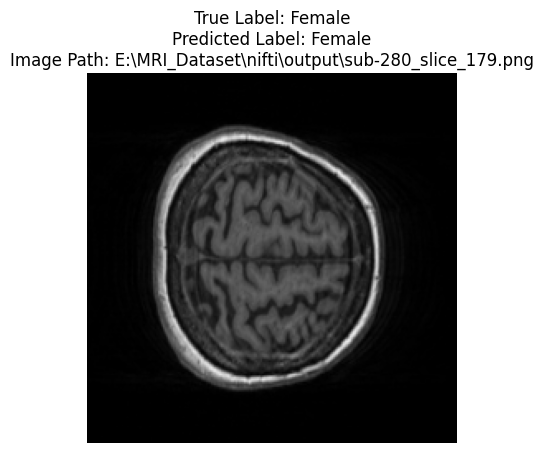

In [54]:
import matplotlib.pyplot as plt

# Iterate over the validation loader to access individual samples
for images, labels, image_paths in valid_loader:
    # Select a sample image, its label, and the image path
    image = images[0]
    label = labels[0].item()
    image_path = image_paths[0]

    # Preprocess the image (e.g., resize and convert to numpy array if necessary)
    preprocessed_image = image.permute(1, 2, 0).numpy()

    # Forward pass the preprocessed image through the model
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)
        _, predicted = torch.max(output, dim=1)

    # Map label and prediction indices to their corresponding class names
    class_names = ['Female', 'Male']
    label_name = class_names[label]
    predicted_name = class_names[predicted.item()]

    # Display the image with label, prediction, and image path
    plt.imshow(preprocessed_image)
    plt.title(f'True Label: {label_name}\nPredicted Label: {predicted_name}\nImage Path: {image_path}')
    plt.axis('off')
    plt.show()

    # Display only one sample for demonstration purposes
    break